In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

In [229]:
def one_hot_encode(dataset, columns, drop=None):

  categories = []
  ret_columns = []

  if isinstance(columns, str):
    columns = [columns]
  if (drop is not None) and (isinstance(drop, str)):
    drop = [drop]

  for i in range(0, len(columns)):
    ctg = dataset.loc[:, columns[i]].unique().tolist()
    categories.append(ctg)

    ctg_ = ctg.copy();
    if drop is not None:
      ctg_.remove(drop[i])
    ret_columns += ctg_

  encoder = OneHotEncoder(categories=categories, drop=drop).fit(dataset[columns])
  ds = pd.DataFrame(encoder.transform(dataset[columns]).toarray(), columns=ret_columns)

  return ds

In [230]:
def add_dummies(dataset, columns, drop_cat=None, drop_col=True):
  dummies = one_hot_encode(dataset, columns, drop_cat)
  if drop_col:
    dataset.drop(columns=columns, inplace=True)
  dataset = pd.concat([dataset, dummies], axis=1)
  return dataset

In [231]:
def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)

def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)

  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  print('Confusion matrix:\n', metrics.confusion_matrix(y_test, y_pred))
  return y_test, y_pred

In [232]:
def balanced_subsample(X, y, subsample_size=1.0):

    classes = y.unique()
    min_elems = y.value_counts().min()

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems * subsample_size)

    Xb = pd.DataFrame()
    yb = pd.Series()

    for c in classes:
      X_ = X[y == c]
      if X_.shape[0] > use_elems:
        X_ = X_.sample(use_elems)

      yc = np.empty(use_elems)
      yc.fill(c)
      y_ = pd.Series(yc)

      Xb = pd.concat([Xb, X_])
      yb = pd.concat([yb, y_])

    return Xb, yb

# Parte 1: Analisi

1. Caricare il dataset e denominarlo con una variabile chiamata “dataset”

In [233]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/employees.csv')

2. Quante sono le istanze contenute nel dataset? Il dataset è completo (cioè per
ogni istanza tutti i valori di attributo sono sempre specificati – non esistono “missing
values”)? Il dataset è bilanciato per quanto riguarda la classe da predire? Osservando direttamente i dati, in che modo l’avere avuto una promozione
negli ultimi 5 anni ha influito sulla scelta del dipendente di abbandonare l’impresa?

In [234]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [235]:
dataset.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [236]:
dataset['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

In [237]:
pd.crosstab(dataset['promotion_last_5years'], dataset['left'])

left,0,1
promotion_last_5years,,
0,11128,3552
1,300,19


3. Guardando la media e la mediana si evince che i dipendenti che lavorano
nell’impresa sono in generale soddisfatti?

In [238]:
dataset['satisfaction_level'].describe()

count    14999.000000
mean         0.612834
std          0.248631
min          0.090000
25%          0.440000
50%          0.640000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

Se si rappresenta un istogramma della soddisfazione dei dipendenti (usare il parametro
bins=100 nella funzione che realizza l’istogramma) si osserva che c’è un blocco iniziale
di dipendenti per nulla soddisfatti. Calcolare il valore di insoddisfazione di questo blocco di dipendenti.

Che cosa hanno in comune questi dipendenti (a parte il livello di soddisfazione basso)?

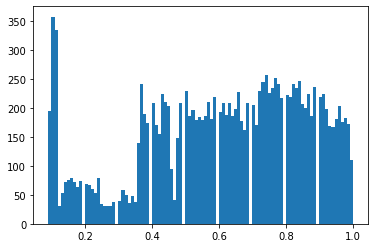

In [239]:
_, bins, _ = plt.hist(dataset['satisfaction_level'], bins=100)

In [240]:
first_bin = dataset[(dataset['satisfaction_level'] >= bins[0]) & (dataset['satisfaction_level'] < bins[1])]

In [241]:
first_bin.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,1.950000e+02,195.000000,195.000000,195.000000,195.000000,195.000000,195.0,195.0
mean,9.000000e-02,0.871538,6.179487,275.692308,4.107692,0.020513,1.0,0.0
std,9.739457e-17,0.070789,0.595161,20.310672,0.398052,0.142111,0.0,0.0
min,9.000000e-02,0.620000,3.000000,214.000000,2.000000,0.000000,1.0,0.0
25%,9.000000e-02,0.820000,6.000000,257.500000,4.000000,0.000000,1.0,0.0
50%,9.000000e-02,0.870000,6.000000,275.000000,4.000000,0.000000,1.0,0.0
75%,9.000000e-02,0.935000,6.500000,294.000000,4.000000,0.000000,1.0,0.0
max,9.000000e-02,0.980000,7.000000,310.000000,5.000000,1.000000,1.0,0.0


In [242]:
for c in first_bin.columns:
  vc = first_bin[c].value_counts()
  if vc.size == 1:
    print(vc)

0.09    195
Name: satisfaction_level, dtype: int64
1    195
Name: left, dtype: int64
0    195
Name: promotion_last_5years, dtype: int64


Noto che in questo blocco nessun dipendente è stato promosso e tutti hanno lasciato l'azienda

4. Rappresentare in un grafico il salario dei dipendenti insoddisfatti descritti nel punto
precedente.

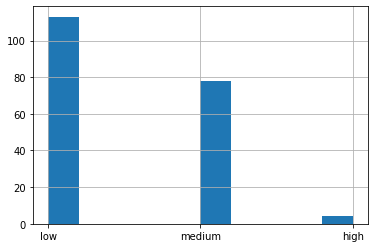

In [243]:
first_bin['salary'].hist()

5. Analizzare i settori (attributo “sales”) in cui i dipendenti insoddisfatti sono collocati.
C’è un settore che è maggiormente fonte di disagio?

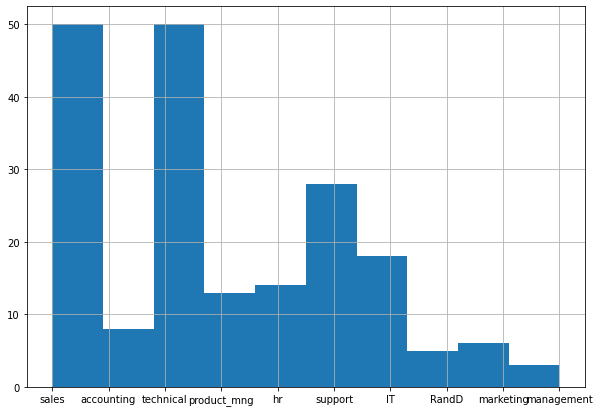

In [244]:
first_bin['sales'].hist(figsize=(10, 7))

# Parte 2: Trasformazione e Predizione

1. Creare un nuovo dataset dal precedente e chiamarlo reduced in si considerano
unicamente le feature numeriche.

In [245]:
reduced = dataset.drop(columns=['salary', 'sales'])

In [246]:
reduced.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
0,0.38,0.53,2,157,3,0,1,0
1,0.80,0.86,5,262,6,0,1,0
2,0.11,0.88,7,272,4,0,1,0
3,0.72,0.87,5,223,5,0,1,0
4,0.37,0.52,2,159,3,0,1,0


2. Nel dataset originale, trasformare i valori dei campi non numerici in numerici,
utilizzando una opportuna funzione di trasformazione.

In [247]:
dataset['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [248]:
dataset['sales'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [249]:
from sklearn.preprocessing import OrdinalEncoder

salary = ['low', 'medium', 'high']
sales = dataset['sales'].unique()

enc = OrdinalEncoder(categories=[salary, sales]).fit(dataset[['salary', 'sales']])
ds = pd.DataFrame(enc.transform(dataset[['salary', 'sales']]), columns=['salary', 'sales'])

dataset2 = pd.concat([dataset.drop(columns=['salary', 'sales']), ds], axis=1)
dataset2.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,sales
0,0.38,0.53,2,157,3,0,1,0,0.0,0.0
1,0.80,0.86,5,262,6,0,1,0,1.0,0.0
2,0.11,0.88,7,272,4,0,1,0,1.0,0.0
3,0.72,0.87,5,223,5,0,1,0,0.0,0.0
4,0.37,0.52,2,159,3,0,1,0,0.0,0.0


3. Si vuole predire il il fatto che un dipendente abbia lasciato o meno l’impresa (feature left) sulla base degli altri attributi presenti nel dataset. Dividere i due dataset (quello originale e quello ridotto) in modo che ¾ degli elementi siano contenuti in un nuovo dataset “train” e ¼ nel dataset “test”.
Valutare l’accuracy ottenuta con il modello MultinomialNB su entrambi i dataset
(from sklearn.naive_bayes import MultinomialNB)

4. Il valore di accuratezza ottenuto è pari a? Cosa si scopre analizzando le confusion matrix?

In [250]:
train, test = train_test_split(dataset2, train_size=.75, random_state=1)
_ = fit_predict_print(train, test, 'left', MultinomialNB())

Accuracy: 0.7674666666666666
Confusion matrix:
 [[2839   14]
 [ 858   39]]


In [251]:
train, test = train_test_split(reduced, train_size=.75, random_state=1)
_ = fit_predict_print(train, test, 'left', MultinomialNB())

Accuracy: 0.7608
Confusion matrix:
 [[2853    0]
 [ 897    0]]


5. Se si utilizza un modello basato su Decision Tree che valore di accuratezza si ottiene?
Cambia qualcosa nella confusion matrix?

In [252]:
train, test = train_test_split(dataset2, train_size=.75, random_state=1)
_ = fit_predict_print(train, test, 'left', DecisionTreeClassifier())

Accuracy: 0.9752
Confusion matrix:
 [[2788   65]
 [  28  869]]


In [253]:
train, test = train_test_split(reduced, train_size=.75, random_state=1)
_ = fit_predict_print(train, test, 'left', DecisionTreeClassifier())

Accuracy: 0.9765333333333334
Confusion matrix:
 [[2790   63]
 [  25  872]]


6. Che valore di accuratezza si ottiene con un 5 Fold cross validation e il modello basato su Decision Tree e il modello basato su MultinomialNB?

In [254]:
X = dataset2.drop(columns='left')
y = dataset2['left']

In [255]:
cross_val_score(MultinomialNB(), X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()

0.7624486606646661

In [256]:
cross_val_score(DecisionTreeClassifier(), X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()

0.9757317772590864

7. Creare un dataset bilanciato rispetto l’attributo “left”, e verificare se cambia l’accuratezza con un 5 Fold cross validation e il modello basato su Decision Tree e il modello basato su MultinomialNB.

In [257]:
Xb, yb = balanced_subsample(X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


In [258]:
print(Xb.shape)
print(yb.value_counts())

(7142, 9)
0.0    3571
1.0    3571
dtype: int64


In [259]:
cross_val_score(MultinomialNB(), Xb, yb, cv=5, scoring='accuracy', n_jobs=-1).mean()

0.655137772393772

In [260]:
cross_val_score(DecisionTreeClassifier(), Xb, yb, cv=5, scoring='accuracy', n_jobs=-1).mean()

0.9680773219014688

8. Creare une versione 1-of-V della matrice (indicator matrix) per quanto riguarda le colonne “sales” e “salary”. Si tratta di una matrice in cui ogni colonna è trasformata in un numero di colonne pari alla cardinalità (i valori unici) del dominio della colonna originale. Ogni cella nella colonna assume un valore 0 o 1 a seconda del fatto che il valore inizialmente contenuto dall’attributo sia uguale a quello rappresentato dalla colonna
Calcolare l’accuratezza con i metodi precedenti. Migliora o peggiora? Questo tipo di trasformazione è in generale migliore o peggiore di quella effettuata al punto 2?

In [261]:
dataset3 = dataset.copy()

In [262]:
dataset3 = add_dummies(dataset3, ['salary', 'sales'])
dataset3.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,low,medium,high,sales,accounting,hr,technical,support,management,IT,product_mng,marketing,RandD
0,0.38,0.53,2,157,3,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.80,0.86,5,262,6,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.11,0.88,7,272,4,0,1,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.72,0.87,5,223,5,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.37,0.52,2,159,3,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
X = dataset3.drop(columns='left')
y = dataset3['left']

In [264]:
cross_val_score(MultinomialNB(), X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()

0.757115838612871

In [265]:
cross_val_score(DecisionTreeClassifier(), X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()

0.9758652439702123